In [68]:
source("../wwa_model-fitting.R")
source("../00_model-fitting-dev/multivariate/model-fitting_multi-covariate.R")

resid <- function(mdl) {mdl$x - ns_pars(mdl)$loc}

## Load data

In [300]:
# load data
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino_ann <- read.csv("nino34_ann.csv", col.names = c("year", "nino34_ann"))
nino_djf <- read.csv("nino34_djf.csv", col.names = c("year", "nino34_djf"))

hi <- read.csv("hi5day.csv", col.names = c("year", "hi"))

# compile into a single dataframe
df <- merge(merge(merge(gmst, nino_ann), nino_djf), hi)

# get covariates
cov_2023 <- df[df$year == 2023, c("gmst", "nino34_djf")]
cov_hist <- cov_2023 - c(1.2,0)
cov_neut <- cov_2023 - c(0, cov_2023$nino34_djf)
cov_neuthist <- cov_2023 - c(1.2, cov_2023$nino34_djf)

## Fit nonstationary model

In [301]:
mdl_gmst <- fit_ns("gev", "shift", df, "hi", c("gmst"))
mdl_ninoann <- fit_ns("gev", "shift", df, "hi", c("gmst", "nino34_ann"))
mdl_ninodjf <- fit_ns("gev", "shift", df, "hi", c("gmst", "nino34_djf"))

mdl_excl <- fit_ns("gev", "shift", df[df$year < 2023,], "hi", c("gmst", "nino34_djf"), ev = hi$hi[hi$year == 2023])

In [ ]:
# which gives the best overall fit?
cat("GMST only                   ",aic(mdl_gmst),"\n")
cat("GMST + Nino34 (Jul-Jun mean)",aic(mdl_ninoann),"\n")
cat("GMST + Nino34 (DJF mean)    ",aic(mdl_ninodjf),"\n")           # best fit although very similar results to when we use annual Nino34

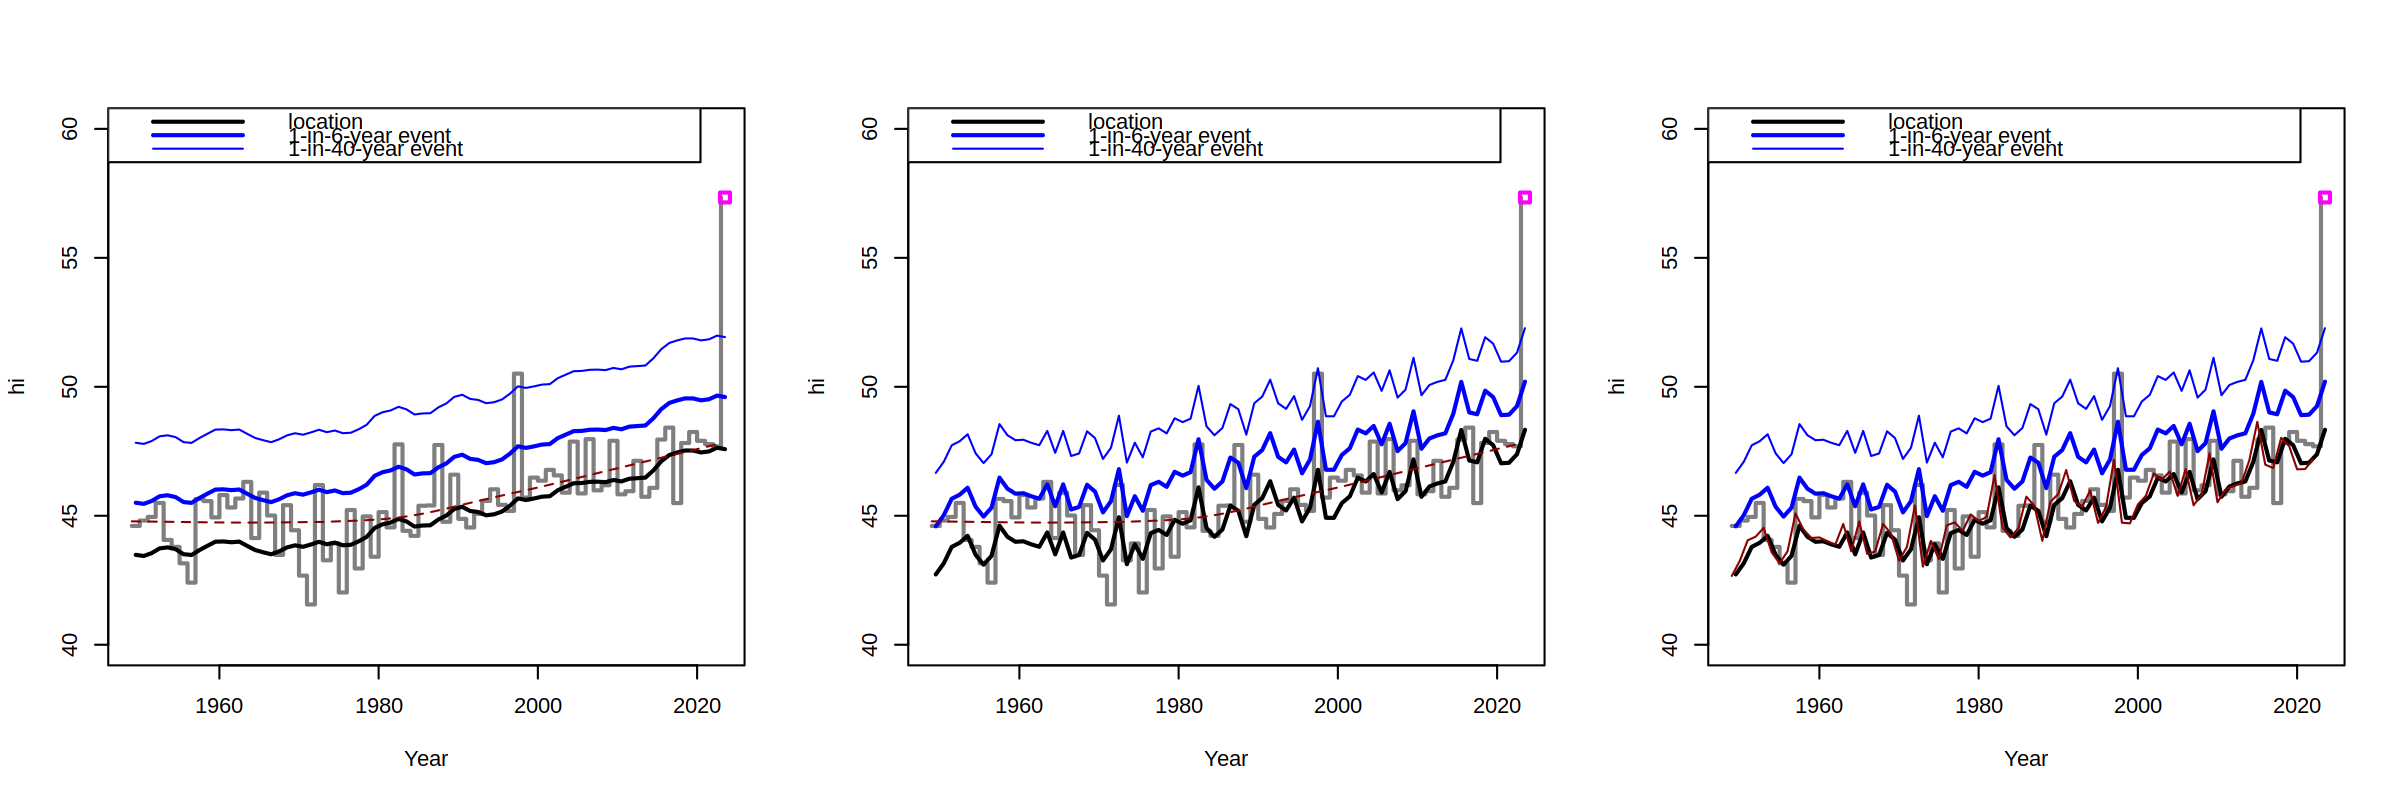

In [314]:
# compare the fitted trends in the three candidate models
prep_window(c(1,3))

# GMST trend vs simple lowess smoother
plot_trend(mdl_gmst)
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

plot_trend(mdl_ninodjf)
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

# check leverage of 2023 event by comparing fit without it: actually not making a massive difference to the trend
plot_trend(mdl_ninodjf)
lines(df$year[df$year < 2023], ns_pars(mdl_excl)$loc, col = "red4")

### Visualise the chosen model

In [378]:
# any trends in residuals?
prep_window(c(1,3))

ylim <- c(40,60)

png("fig/fitted-trend.png", height = 480, width = 480*3); par(mfrow = c(1,3), cex.main = 1.4); {

    par(oma = c(0,0,2,0))
    
    plot_trend(mdl_ninodjf, ylim = ylim, main = "over time")
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    o <- order(df$gmst)
    gmst_cov <- data.frame(gmst = df$gmst, nino34_djf = mean(df$nino34_djf))[o,]
    plot(df$gmst, df$hi, ylim = ylim, main = "vs GMST", pch = 20)
    points(df[df$year == 2023, c("gmst", "hi")], col = "magenta", pch = 0)
    lines(df$gmst[o], ns_pars(mdl_ninodjf, fixed_cov = gmst_cov)$loc, lwd = 2)
    lines(df$gmst[o], eff_return_level(mdl_ninodjf, 6, fixed_cov = gmst_cov), lwd = 2, col = "blue")
    lines(df$gmst[o], eff_return_level(mdl_ninodjf, 40, fixed_cov = gmst_cov), lwd = 1, col = "blue")
    lines(df$gmst[o], ns_pars(mdl_gmst, fixed_cov = gmst_cov[,"gmst",drop=F])$loc, lwd = 2, col = "forestgreen")
    lines(df$gmst[o], eff_return_level(mdl_gmst, 6, fixed_cov = gmst_cov[,"gmst",drop=F]), lwd = 2, col = "forestgreen")
    lines(df$gmst[o], eff_return_level(mdl_gmst, 40, fixed_cov = gmst_cov[,"gmst",drop=F]), lwd = 1, col = "forestgreen")
    legend("topleft", c("GMST only", "Nino + GMST"), lty =1, col = c("forestgreen", "blue"))

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    o <- order(df$nino34_djf)
    nino_cov <- data.frame(gmst = mean(df$gmst), nino34_djf = df$nino34_djf)[o,]
    plot(df$nino34_djf, df$hi, ylim = ylim, main = "vs Nino34 (DJF)", pch = 20)
    points(df[df$year == 2023, c("nino34_djf", "hi")], col = "magenta", pch = 0)
    lines(df$nino34_djf[o], ns_pars(mdl_ninodjf, fixed_cov = nino_cov)$loc, lwd = 2)
    lines(df$nino34_djf[o], eff_return_level(mdl_ninodjf, 6, fixed_cov = nino_cov), lwd = 2, col = "blue")
    lines(df$nino34_djf[o], eff_return_level(mdl_ninodjf, 40, fixed_cov = nino_cov), lwd = 1, col = "blue")
    abline(v = 0, lty = 2)
    
    mtext("Fitted trend: hi ~ gmst + nino3.4", outer = T, font = 2)
}; dev.off()

png 
  2

### Check model fit

In [350]:
# any trends in residuals?
prep_window(c(1,3))

ylim <- c(-2.5,9)

png("fig/residuals.png", height = 480, width = 480*3); par(mfrow = c(1,3), cex.main = 1.4); {
    par(oma = c(0,0,2,0))

    plot(df$year, resid(mdl_ninodjf), ylim = ylim, main = "vs time", col = "darkblue")
    # points(df$year[1:74], resid(mdl_excl), col = "darkred", pch = 4)
    points(2023, resid(mdl_ninodjf)[df$year == 2023], col = "magenta", pch = 0)
    abline(line(df$year, resid(mdl_ninodjf)), lwd = 2, col = "blue")
    abline(line(mdl_excl$data$year, resid(mdl_excl)), lwd = 2, col = "red")
    abline(h = 0, lty = 2)
    
    plot(df$gmst, resid(mdl_ninodjf), ylim = ylim, main = "vs GMST", col = "darkblue", pch = 20)
    points(df$gmst[df$year == 2023], resid(mdl_ninodjf)[df$year == 2023], col = "magenta", pch = 0)
    # points(df$gmst[1:74], resid(mdl_excl), col = "darkred", pch = 4)
    abline(line(df$gmst, resid(mdl_ninodjf)), lwd = 2, col = "blue")
    abline(line(mdl_excl$data$gmst, resid(mdl_excl)), lwd = 2, col = "red")
    abline(h = 0, lty = 2)
    
    legend("topleft", c("Including 2023-24", "Excluding 2023-24"), col = c("blue", "red"), lty = 1, lwd = 2, bty = "n")
    
    plot(df$nino34_djf, resid(mdl_ninodjf), ylim = ylim, main = "vs Nino3.4", col = "darkblue", pch = 20)
    points(df$nino34_djf[df$year == 2023], resid(mdl_ninodjf)[df$year == 2023], col = "magenta", pch = 0)
    # points(df$nino34_djf[1:74], resid(mdl_excl), col = "darkred", pch = 4)
    abline(line(df$nino34_djf, resid(mdl_ninodjf)), lwd = 2, col = "blue")
    abline(line(mdl_excl$data$nino34_djf, resid(mdl_excl)), lwd = 2, col = "red")
    abline(h = 0, v = 0, lty = 2)
    
    mtext("Trend in residuals (residuals from model including 2023 shown)", outer = T, font = 2)
    
    # slight downward trend in residuals when 2023 event is included - almost flat when 2023 is excluded from model fit
}; dev.off()

png 
  2

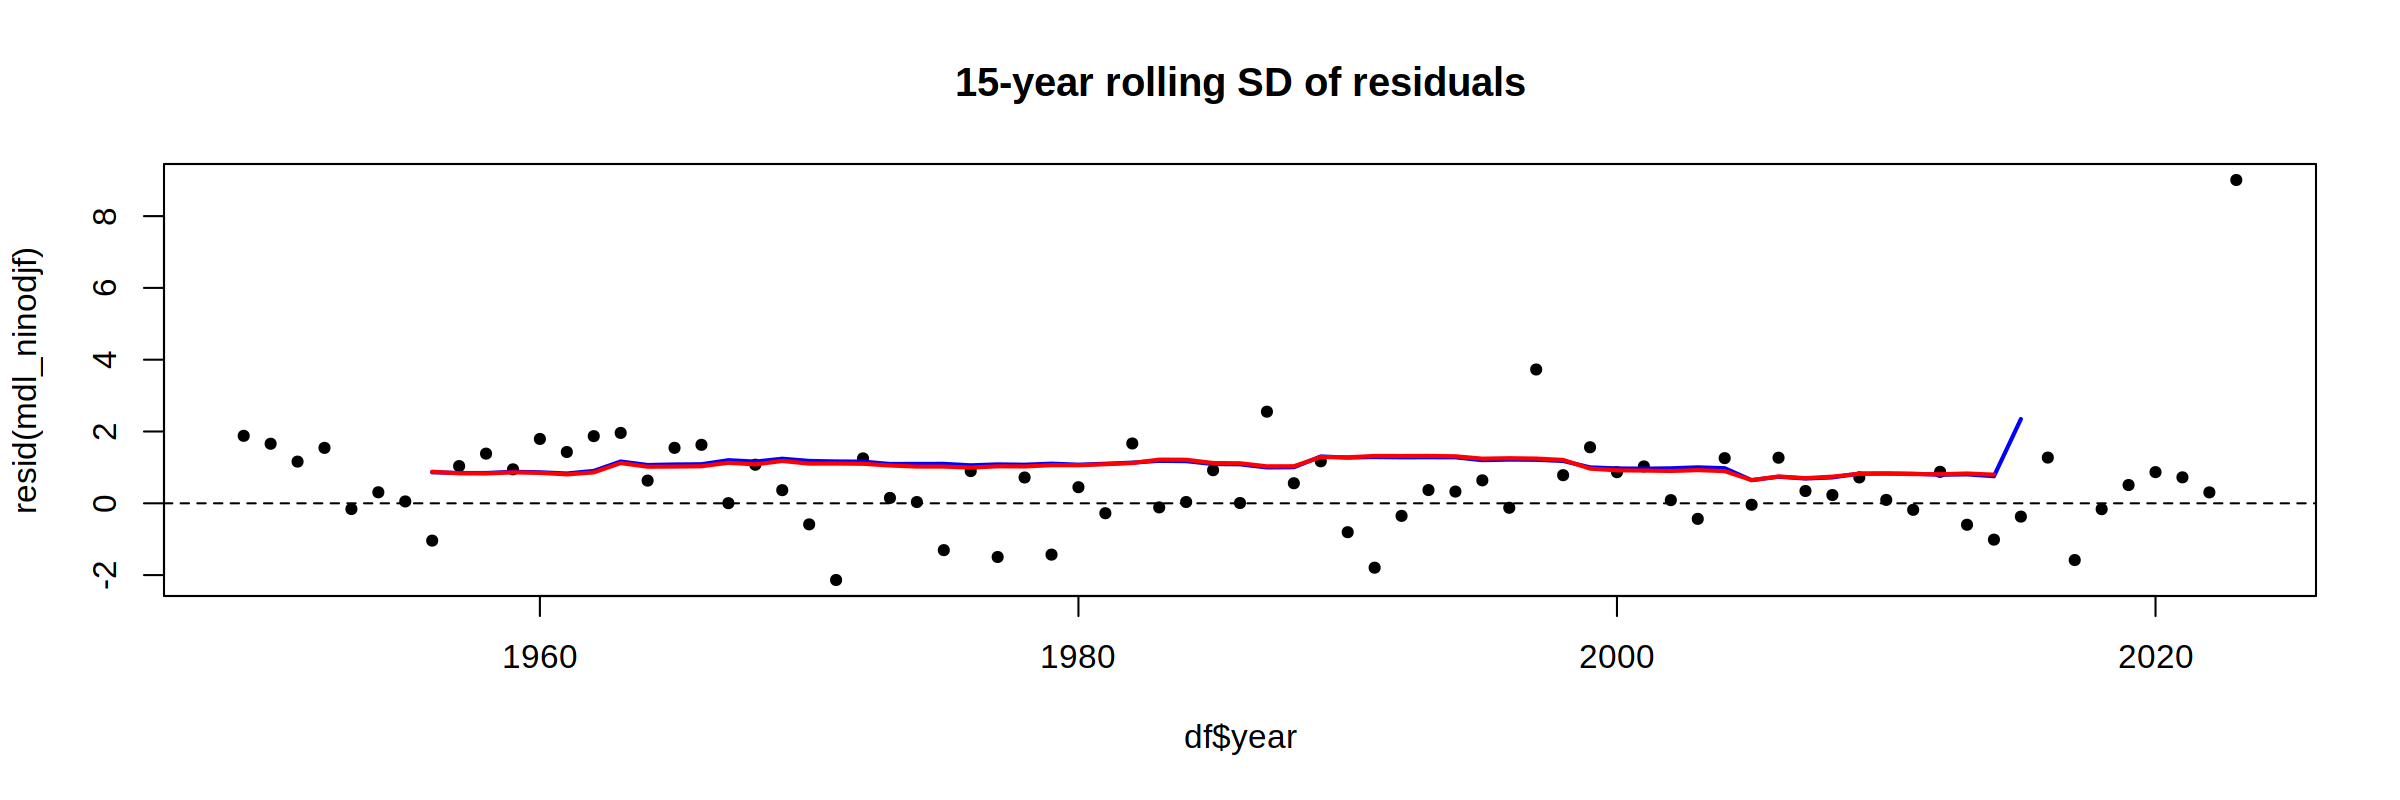

In [315]:
# standard deviation of the residuals - pretty flat either way
plot(df$year, resid(mdl_ninodjf), pch = 20, main = "15-year rolling SD of residuals")
lines(df$year[8:(nrow(df)-8)], sapply(1:(nrow(df)-15), function(ys) { sd(resid(mdl_ninodjf)[ys+(0:15)]) }), type = "l", lwd = 2, col = "blue")
lines(df$year[8:(nrow(df)-8)], sapply(1:(nrow(df)-15), function(ys) { sd(resid(mdl_excl)[ys+(0:15)]) }), type = "l", col = "red", lwd = 2)
abline(h = 0, lty = 2)

### Include or exclude the event?

In [ ]:
# have to fix RP when excluding event, otherwise PR etc will fail

set.seed(42)
res_incl <- boot_ci(mdl_ninodjf, cov = cov_2023, cov_cf = cov_hist, nsamp = 1000)
res_excl <- boot_ci(mdl_excl, cov = cov_2023, cov_cf = cov_hist, nsamp = 1000, rp = 5000, ev = eff_return_level(mdl_excl, 100, fixed_cov = cov_2023))

# estimate PR & change in intensity due to positive Nino phase
res_neut_incl <- boot_ci(mdl_ninodjf, cov = cov_2023, cov_cf = cov_neut, nsamp = 1000)
res_neut_excl <- boot_ci(mdl_excl, cov = cov_2023, cov_cf = cov_neut, nsamp = 1000, rp = 5000, ev = eff_return_level(mdl_excl, 100, fixed_cov = cov_2023))

rownames(res_neut_incl) <- paste0(rownames(res_neut_incl), "_nino")
rownames(res_neut_excl) <- paste0(rownames(res_neut_excl), "_nino")

res_incl <- rbind(res_incl, res_neut_incl[c("PR_nino", "dI_abs_nino"),])
res_excl <- rbind(res_excl, res_neut_excl[c("PR_nino", "dI_abs_nino"),])

In [365]:
plot_pars <- c("alpha_gmst", "alpha_nino34_djf", "shape", "return_period", "PR", "dI_abs", "PR_nino", "dI_abs_nino")
prep_window(c(1,4)); 

png("fig/parameter-estimates.png", height = 480, width = 480*3); par(cex.main = 2); {
    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- rbind("2023_incl" = res_incl[r,], "2023_excl" = res_excl[r,])
        res[,"bestimate"][!is.finite(res[,"bestimate"])] <- res[!is.finite(res[,"bestimate"]),"2.5%"]
        res[,"97.5%"][!is.finite(res[,"97.5%"])] <- res[!is.finite(res[,"97.5%"]),"bestimate"]
        
        n <- nrow(res)
        plot(0, type = "n", ylim = range(res, na.rm = T), xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "")
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(c("blue", "red"), alpha = 0.4))
        points(1:n, res[,"bestimate"], pch = 20, cex = 2)
        if(grepl("PR", r)) abline(h = 1, lty = 2) else abline(h = 0, lty = 2)
    }
}; dev.off()

png 
  2

### Return level plots

In [348]:
ylim <- c(40,60)
prep_window(c(1,3))

png("fig/returnlevels_gmst.png", height = 480, width = 480 * 2.5); par(cex.main = 1.4); {
    par(mfrow = c(1,2))
    plot_returnlevels(mdl_ninodjf, cov = cov_2023, cov_cf = cov_hist, ylim = ylim, main = "Include 2023")
    plot_returnlevels(mdl_excl, cov = cov_2023, cov_cf = cov_hist, ylim = ylim, main = "Exclude 2023")
}; dev.off()


png 
  2

In [349]:
ylim <- c(40,60)
prep_window(c(1,3)); 
png("fig/returnlevels_nino.png", height = 480, width = 480 * 2.5); par(cex.main = 1.4); {
    par(mfrow = c(1,2))
    plot_returnlevels(mdl_ninodjf, cov = cov_2023, cov_cf = cov_neut, ylim = ylim, main = "Include 2023")
    plot_returnlevels(mdl_excl, cov = cov_2023, cov_cf = cov_neut, ylim = ylim, main = "Exclude 2023")
}; dev.off()

png 
  2